In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import sparse
from scipy import ndimage
from skimage import io
from scipy import ndimage
import time

# from ripser import ripser
# from persim import plot_diagrams

import importlib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import *

import dionysus as d
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
rcParams.update({'font.size': 12})

In [5]:
# img_crop = io.imread('../../ImageAnalysis/ShiqiongData/SingleSiteZProj/AVG_2umIgG_pha568_pax-GFP 008_Reconstructed (zzzy).nd2 - C=0.tif')
img_crop = io.imread('../../ImageAnalysis/ShiqiongData/002_AP_Act_Max_Single_Site_Crop2.tif')

# img_crop = img_crop-np.min(img_crop)
pix_size = 5.10/126 #um
len_micron = int(1/pix_size)

pod_smooth = int(0.2*len_micron)
site_smooth = int(1.5*len_micron)

In [6]:
np.shape(img_crop)

(120, 126)

(-0.5, 125.5, 119.5, -0.5)

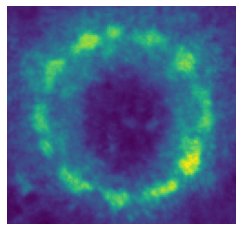

In [7]:
plt.figure()
plt.imshow(img_crop)
plt.axis('off')

In [8]:
img_pod = img_crop.astype(np.float64) #[::2].T[::2].T.astype(np.float64)
img_pod = ndimage.uniform_filter(img_pod, size=pod_smooth) #Smooth image
img_pod += 0.01 * np.random.randn(*img_pod.shape) #Make each pixel's value unique

In [9]:
f_upper_star = d.fill_freudenthal(img_pod, reverse = True)

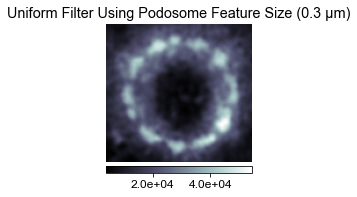

In [10]:
plt.figure(figsize=(2.9,2.9))
plt.title('Uniform Filter Using Podosome Feature Size (0.3 \u03BCm)')
# plt.title('Smoothed Image')
im = plt.imshow(img_pod,cmap=plt.cm.bone)
plt.axis('off')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(im, cax=cax,orientation="horizontal",format='%.1e',ticks=[2e4,4e4])
plt.tight_layout()
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI+Methods/IndividualPlots/Methods_SingleSite_Site2.pdf",transparent=True,dpi=300,bbox_inches='tight')


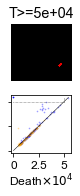

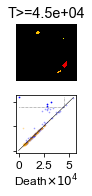

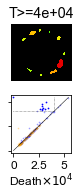

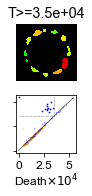

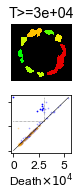

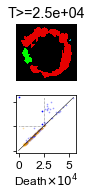

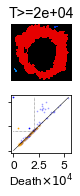

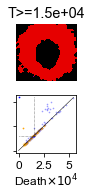

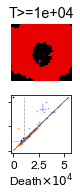

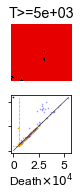

In [11]:
a = img_pod

from mpl_toolkits.axes_grid1 import make_axes_locatable

p = d.homology_persistence(f_upper_star)
dgms = d.init_diagrams(p, f_upper_star)

pers_dio = []
for h, dgm in enumerate(dgms):
    for pt in dgm:
        pers_dio.append([h,pt.birth,pt.death])

pers_dio = np.asarray(pers_dio)

# for ind,thresh in enumerate(np.linspace(5.0e4,500,98)):
for ind,thresh in enumerate(np.linspace(5.0e4,0.5e4,10)):
    plt.figure(figsize=(1.2,2.4))

#     plt.title('Mask')
#     plt.imshow(a>thresh,cmap=plt.cm.bone)

    plt.subplot(2,1, 1)
    
    labels, nb = ndimage.label(a>=thresh)

    if len(set(labels.flatten())) == 1:
        new_labeling = labels*np.max(a[labels==np.max(labels)])
    else:
        labels_to_combine = []
        for i in np.arange(1,np.shape(a)[0]):
            for j in np.arange(1,np.shape(a)[1]):
                if labels[i,j] > 0 and labels[i-1,j-1] >0 and labels[i,j] != labels[i-1,j-1]:
                    labels_to_combine.append([labels[i,j],labels[i-1,j-1]])

        if len(labels_to_combine)>0:
            labels_to_combine = np.unique(np.sort([np.sort(pair) for pair in labels_to_combine]),axis=1)

            combined_labels = labels
            for p1,p2 in labels_to_combine[::-1]:
                combined_labels[labels == p2] = p1

            new_labels = np.arange(len(np.unique(combined_labels)))
            old_labels = np.unique(combined_labels)

            for l in new_labels:
                combined_labels[combined_labels== old_labels[l]] = new_labels[l]

            labels = combined_labels

        label_maxs = [np.max(a[labels==i]) for i in range(np.max(labels)+1)]

        sorted_labels = np.argsort(label_maxs)

        new_labeling = np.zeros(np.shape(a))

        for i in range(np.max(labels)+1):
            if i == 0:
                new_labeling[labels==i] = 0
            else: new_labeling[labels==i] = label_maxs[i]

    plt.title('T>=%s' %format(thresh,'.2g'))
    ax = plt.gca()
    im = plt.imshow(new_labeling, cmap=plt.cm.nipy_spectral,vmin=1e4,vmax=6e4,interpolation='none')

    plt.axis('off')
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     plt.colorbar(im, cax=cax,orientation="vertical", format='%.0e')
    
    plt.tight_layout()

    #Persistence Diagram
    
#     p = d.homology_persistence(f_upper_star)
#     dgms = d.init_diagrams(p, f_upper_star)
    
#     pers_dio = []
#     for h, dgm in enumerate(dgms):
#         for pt in dgm:
#             pers_dio.append([h,pt.birth,pt.death])

#     pers_dio = np.asarray(pers_dio)
    
    plt.subplot(2, 1, 2)
    plt.plot([0,np.max(a)],[0,np.max(a)],c='black',lw=0.5)

    plt.plot([0,thresh],[thresh,thresh],ls=":",c='black',lw=0.5)
    plt.plot([thresh,thresh],[thresh,np.max(a)],ls=":",c='black',lw=0.5)
    for row in pers_dio:
        if row[1] >= thresh and row[2] < thresh:
            al = 1
        elif row[2] == np.inf:
            al = 1
        else: al = 0.3

        if row[0] == 1:
            color = 'orange'
        else: color = 'blue'
        plt.scatter(row[2],row[1],c=color,alpha=al,s=0.5)
        if row[2] == np.inf:
            plt.scatter(0,row[1],c=color,alpha=al,s=0.5)

#     plt.title('Persistence Diagram',y=1.08)
#     plt.ylabel('Birth Level')
    plt.xlabel(r'Death$\times 10^4$',labelpad=2)

    plt.xticks([0,2.5e4,5e4],[0,2.5,5])
    plt.yticks([0,2.5e4,5e4],'')
    
    
#     if ind < 10:
#         plt.savefig('TDAExample/TDA_RingSite2Ex0%i.pdf' %ind,dpi=300,transparent=True,bbox_inches='tight')
#     else:
#         plt.savefig('TDAExample/TDA_RingSite2Ex%i.pdf' %ind,dpi=300,transparent=True,bbox_inches='tight')
#     plt.close()
    
    
    

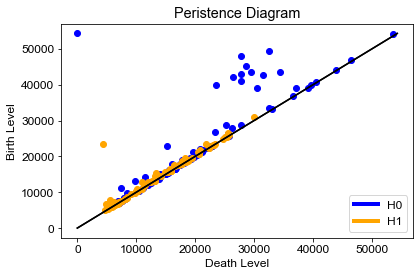

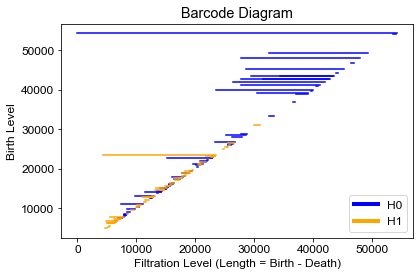

In [13]:
pers_dio[0,2] = 0
pers_dio

plt.plot([0,np.max(a)],[0,np.max(a)],c='black')

plt.plot([0,np.max(a)],[0,np.max(a)],c='black')
for row in pers_dio:
    if row[0] == 1:
        color = 'orange'
    else: color = 'blue'
    plt.scatter(row[2],row[1],c=color)
    if row[2] == np.inf:
        plt.scatter(0,row[1],c=color)

plt.title('Peristence Diagram')
plt.ylabel('Birth Level')
plt.xlabel('Death Level')

custom_lines = [plt.Line2D([0], [0], color='blue', lw=4),
                plt.Line2D([0], [0], color='orange', lw=4)]

plt.legend(custom_lines, ['H0', 'H1'])

plt.tight_layout()

plt.figure(figsize=(6,4))
# plt.plot([0,np.max(a)],[0,np.max(a)],c='black')

# plt.plot([0,np.max(a)],[0,np.max(a)],c='black')
for row in pers_dio:
    if row[0] == 1:
        color = 'orange'
    else: color = 'blue'
        
    plt.plot([row[1],row[2]],[row[1],row[1]], color = color)
#     plt.scatter(row[2],row[1],c=color)
#     if row[2] == np.inf:
#         plt.scatter(0,row[1],c=color)

plt.title('Barcode Diagram')
plt.ylabel('Birth Level')
plt.xlabel('Filtration Level (Length = Birth - Death)')

custom_lines = [plt.Line2D([0], [0], color='blue', lw=4),
                plt.Line2D([0], [0], color='orange', lw=4)]

plt.legend(custom_lines, ['H0', 'H1'])

plt.tight_layout()



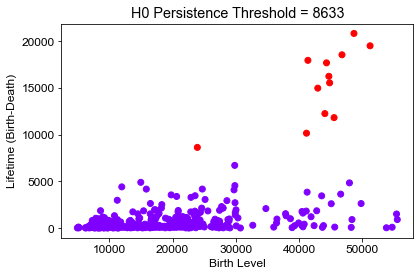

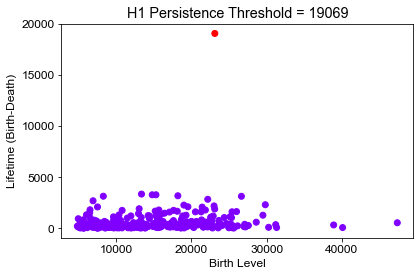

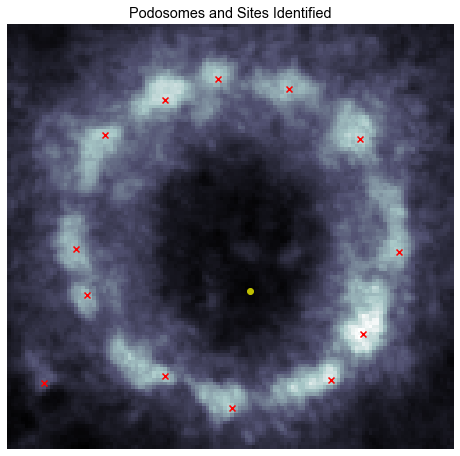

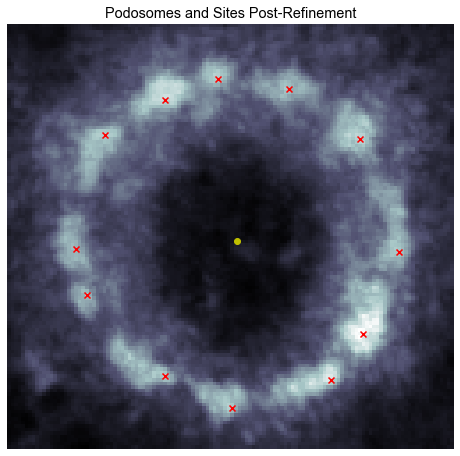

In [19]:
# img_crop = io.imread('../../ImageAnalysis/ShiqiongData/001_AP_Act_Max_Sites_Crop.tif')

# img_crop = img_crop-np.min(img_crop)

len_micron = int(1/pix_size)

pod_filt = int(0.1*len_micron)
site_filt = int(0.1*len_micron)

image_mean = img_crop

pods, sites = find_pod_and_sites_ph(image_mean,pod_filt,site_filt,plot_bool=True,plot_pers=True,save_file = '')
clusters,centers,radii = cluster_refine_pods_and_sites(pods,sites,image_mean,pix_size,plot_bool=True,save_file = '',upper_lim=2.5,lower_lim=1.5)
# all_clusters.append(clusters)
# all_centers.append(centers)


In [20]:
b1 = 8633 
b2 = 19069
theta = np.pi/4
height1 = b1*np.sin(theta)
height2 = b2*np.sin(theta)
print(height1,height2)

6105.159948764651 13483.819210446274


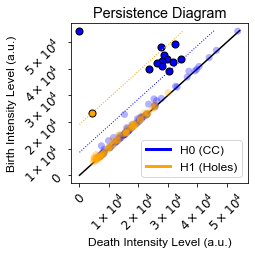

In [21]:
plt.figure(figsize=(3.7,3.7))

thresh_1 = b2-1 #height2 #8000
thresh_2 = b1-1 #height1 #15000
thresh = thresh_1

plt.plot([0,np.max(a)],[0,np.max(a)],c='black',zorder=0)
plt.plot([0,np.max(a)-thresh_1],[thresh_1,np.max(a)],ls=":",c='orange',lw=1)
plt.plot([0,np.max(a)-thresh_2],[thresh_2,np.max(a)],ls=":",c='blue',lw=1)
for row in pers_dio:
    if row[1]-row[2] > thresh_1 and row[0] == 1:
        al = 1
        edge = "k"
    elif row[1]-row[2] > thresh_2 and row[0] == 0:
        al = 1
        edge = "k"
    elif row[2] == np.inf:
        al = 1
        edge = "k"
    else: 
        al = 0.3
        edge = 'None'

    if row[0] == 1:
        color = 'orange'
    else: color = 'blue'
    plt.scatter(row[2],row[1],c=color,alpha=al,s=50,edgecolors=edge)
    if row[2] == np.inf:
        plt.scatter(0,row[1],c=color,alpha=al,s=50,edgecolors=edge)

plt.title('Persistence Diagram')
plt.ylabel('Birth Intensity Level (a.u.)')
plt.xlabel('Death Intensity Level (a.u.)')

custom_lines = [plt.Line2D([0], [0], color='blue', lw=3),
        plt.Line2D([0], [0], color='orange', lw=3)]

plt.legend(custom_lines, ['H0 (CC)', 'H1 (Holes)'],loc='lower right')

plt.xticks([0,1e4,2e4,3e4,4e4,5e4],[r'$0$',r'$1\times10^4$',r'$2\times10^4$',r'$3\times10^4$',r'$4\times10^4$',r'$5\times10^4$'],rotation=45)
plt.yticks([0,1e4,2e4,3e4,4e4,5e4],[r'$0$',r'$1\times10^4$',r'$2\times10^4$',r'$3\times10^4$',r'$4\times10^4$',r'$5\times10^4$'],rotation=45)

plt.tight_layout()
# plt.ticklabel_format(axis="both", style="sci",scilimits=(10e4,10e5),useOffset=True,useMathText=True)
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI+Methods/IndividualPlots/Methods_SingleSitePersistenceDiagram_Site2.pdf",transparent=True,dpi=300)


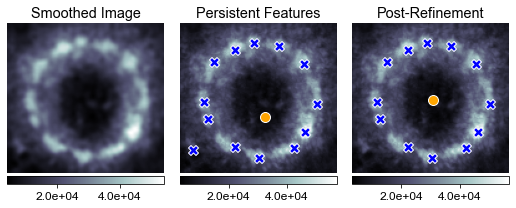

In [22]:
plt.figure(figsize=(9,5))

plt.subplot(1,3,1)
plt.title('Smoothed Image')
im = plt.imshow(img_pod,cmap=plt.cm.bone)
plt.axis('off')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(im, cax=cax,orientation="horizontal",format='%.1e',ticks=[2e4,4e4])
ax = plt.gca()
ax.yaxis.set_ticks_position('left')

# plt.tight_layout()

plt.subplot(1,3,2)

plt.title('Persistent Features')

im = plt.imshow(img_crop,cmap=plt.cm.bone)
plt.scatter(pods.T[0],pods.T[1],color='blue',marker = 'X',s=100,edgecolors='white')
plt.scatter(sites.T[0],sites.T[1],color='orange',marker = 'o',s=100,edgecolors='white')
plt.axis('off')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(im, cax=cax,orientation="horizontal",format='%.1e',ticks=[2e4,4e4])
ax = plt.gca()
ax.yaxis.set_ticks_position('left')

plt.subplot(1,3,3)
plt.title('Post-Refinement')
plt.imshow(img_crop,cmap=plt.cm.bone)
plt.scatter(clusters.T[0],clusters.T[1],color='blue',marker = 'X',s=100,edgecolors='white')
plt.scatter(centers.T[0],centers.T[1],color='orange',marker = 'o',s=100,edgecolors='white')
plt.axis('off')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(im, cax=cax,orientation="horizontal",format='%.1e',ticks=[2e4,4e4])
ax = plt.gca()
ax.yaxis.set_ticks_position('left')

plt.subplots_adjust(wspace=0.1)

# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI+Methods/IndividualPlots/Methods_SingleSiteLocations_Site2.pdf",transparent=True,dpi=300)



In [23]:
image_loc = '../../../SH-CH/talin_actin/'
save_folder = 'AT_Analyzed'
save_file_name = 'AT_Analyzed/AT'
other_species = 'Talin'
# files = ['002','004','008','010']
# pix_sizes = [41.47/1024,41.47/1024,41.47/1024,28.35/700] #um
pod_analysis_distance = 1. #um

file = '010'
pix_size = 28.35/700
len_micron = int(1/pix_size)
images = io.imread(image_loc + file + '_Composite.tif')

actin = images[1]
other = images[0]

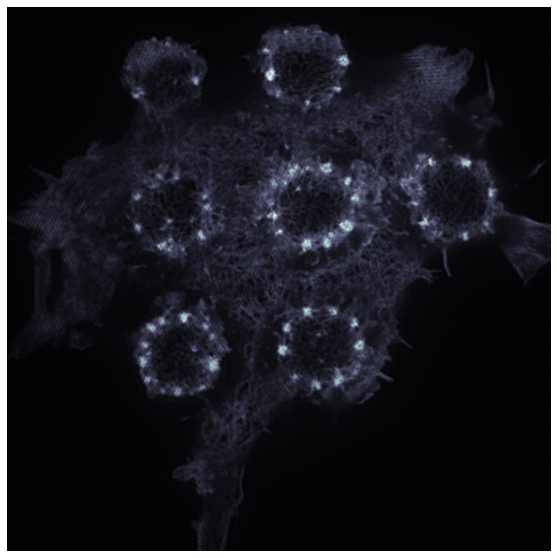

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(actin,cmap=plt.cm.bone)
plt.axis('off')
plt.show()

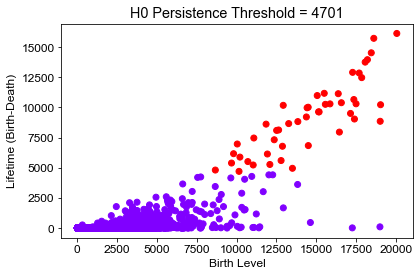

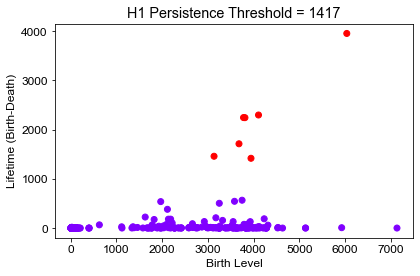

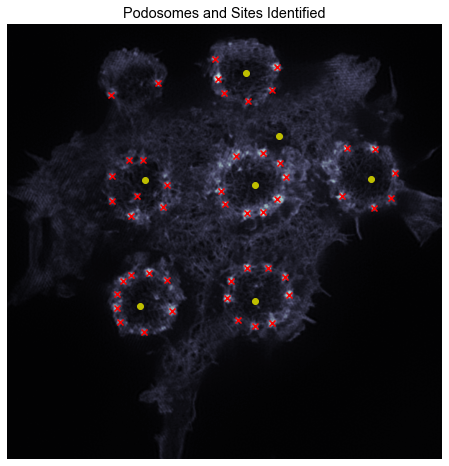

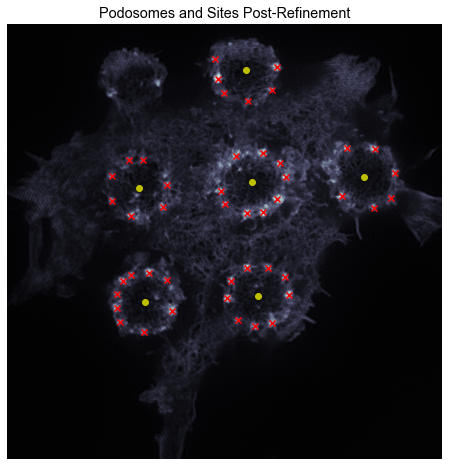

In [51]:
pod_filter = int(0.35*len_micron)
site_filter = int(1.5*len_micron)

pods, sites = find_pod_and_sites_ph(actin,pod_filter,site_filter,plot_bool=True,plot_pers=True,save_file = '')
clusters,centers,radii = cluster_refine_pods_and_sites(pods,sites,actin,pix_size,plot_bool=True,save_file = '',upper_lim=2.5,lower_lim=1.5)

image = actin
img_pod = ndimage.uniform_filter(image.astype(np.float64), size=pod_filter) #Smooth image
img_pod += 0.01 * np.random.randn(*img_pod.shape) #Make each pixel's value unique
img_sites = ndimage.uniform_filter(image.astype(np.float64), size=site_filter) #Smooth image
img_sites += 0.01 * np.random.randn(*img_sites.shape) #Make each pixel's value unique

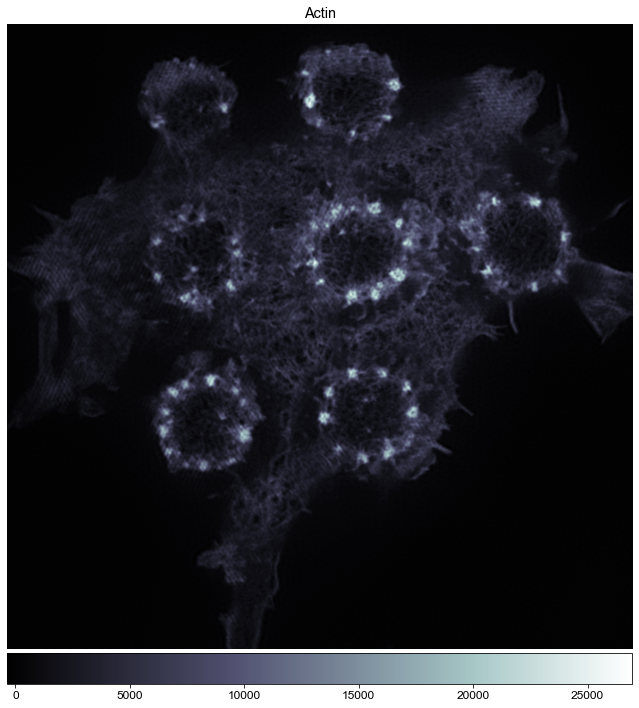

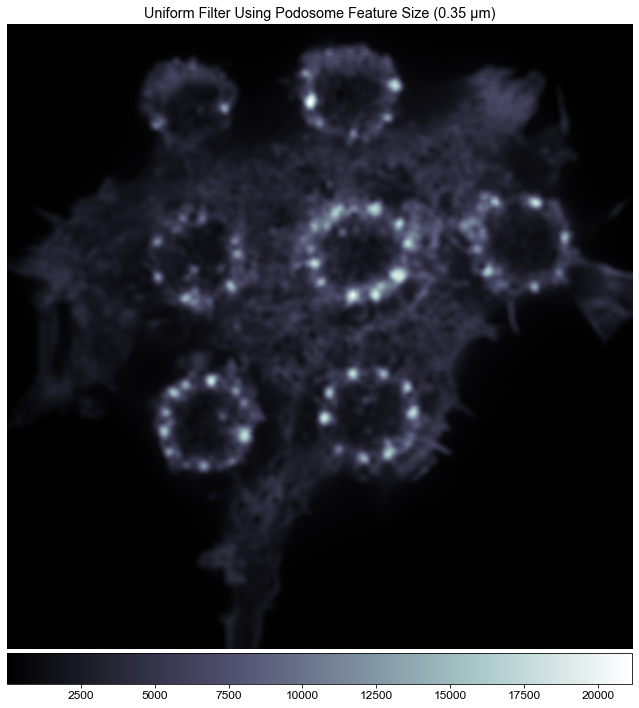

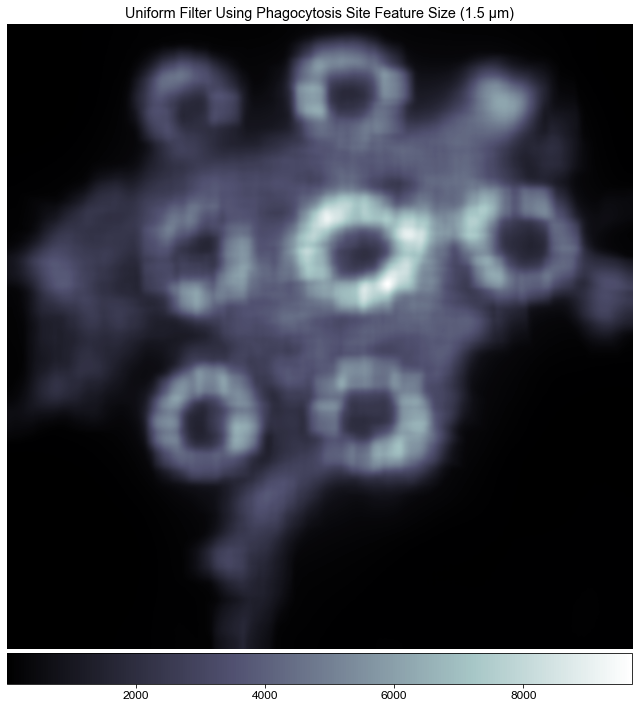

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(10,10))
plt.title('Actin')
im = plt.imshow(actin,cmap=plt.cm.bone)
plt.axis('off')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(im, cax=cax,orientation='horizontal')
plt.tight_layout()
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI/IndividualPlots/ActinTalin010.pdf",transparent=True,dpi=300,bbox_inches='tight',pad_inches = 0)

plt.figure(figsize=(10,10))
plt.title('Uniform Filter Using Podosome Feature Size (0.35 \u03BCm)')
im = plt.imshow(img_pod,cmap=plt.cm.bone)
plt.axis('off')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(im, cax=cax,orientation='horizontal')
plt.tight_layout()
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI/IndividualPlots/PodFeatBlur.pdf",transparent=True,dpi=300,bbox_inches='tight',pad_inches = 0)


plt.figure(figsize=(10,10))
plt.title('Uniform Filter Using Phagocytosis Site Feature Size (1.5 \u03BCm)')
im = plt.imshow(img_sites,cmap=plt.cm.bone)
plt.axis('off')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(im, cax=cax,orientation='horizontal')
plt.tight_layout()
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI/IndividualPlots/SiteFeatBlur.pdf",transparent=True,dpi=300,bbox_inches='tight',pad_inches = 0)



plt.show()

In [53]:
f_upper_star_pod = d.fill_freudenthal(img_pod, reverse = True)
f_upper_star_sites = d.fill_freudenthal(img_sites, reverse = True)

In [54]:
p = d.homology_persistence(f_upper_star_pod)
dgms = d.init_diagrams(p, f_upper_star_pod)

pers_dio = []
for h, dgm in enumerate(dgms):
    for pt in dgm:
        pers_dio.append([h,pt.birth,pt.death])

pers_dio = np.asarray(pers_dio)
pers_dio[0,2] = 0

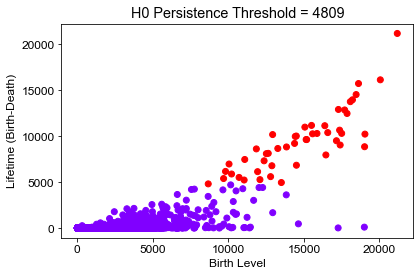

4808.766357421875

In [55]:
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI/IndividualPlots/PodFeatBlur.pdf",transparent=True,dpi=300,bbox_inches='tight',pad_inches = 0)

kmeans_pers_thresh(pers_dio,0,n=2,plot_bool=True,save_file='')

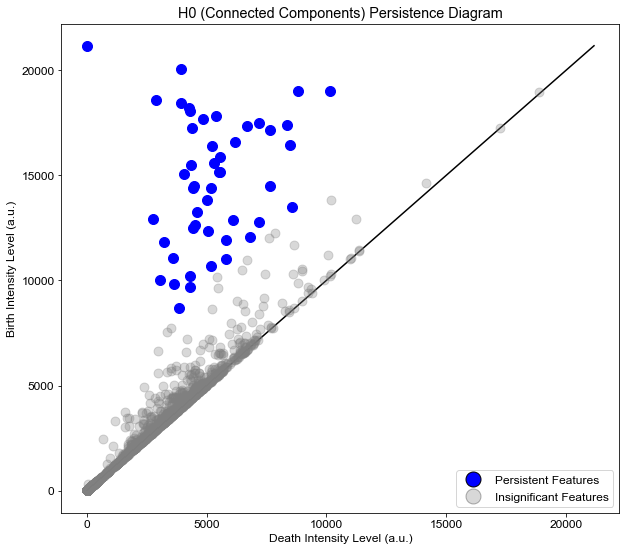

In [56]:
plt.figure(figsize=(10,9))
bt0 = pers_dio[pers_dio.T[0]==0].T[1:][0]
dt0 = pers_dio[pers_dio.T[0]==0].T[1:][1]

plt.scatter(dt0,bt0,alpha=0.3,color='gray',s=80,rasterized=True)

pers_dio_0 = pers_dio[pers_dio.T[0]==0]
pers_dio_sig0 = pers_dio_0[bt0-dt0 > 4809-1]
bt0_sig = pers_dio_sig0.T[1:][0]
dt0_sig = pers_dio_sig0.T[1:][1]

plt.scatter(dt0_sig,bt0_sig,color='blue',s=100,rasterized=True)

plt.title('H0 (Connected Components) Persistence Diagram')
plt.ylabel('Birth Intensity Level (a.u.)')
plt.xlabel('Death Intensity Level (a.u.)')

custom_lines = [plt.Line2D([0], [0],marker='o', color='None', label='Scatter',
                          markerfacecolor='b', markersize=15),
                plt.Line2D([0], [0],marker='o', color='None', label='Scatter',
                          markerfacecolor='gray',alpha=0.3, markersize=15)]

plt.legend(custom_lines, ['Persistent Features','Insignificant Features'])

plt.plot([0,np.max(bt0)],[0,np.max(bt0)],c='black',zorder=0)

# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI/IndividualPlots/PersistenceDiagram_H0.pdf",transparent=True,dpi=300,bbox_inches='tight',pad_inches = 0)
plt.show()

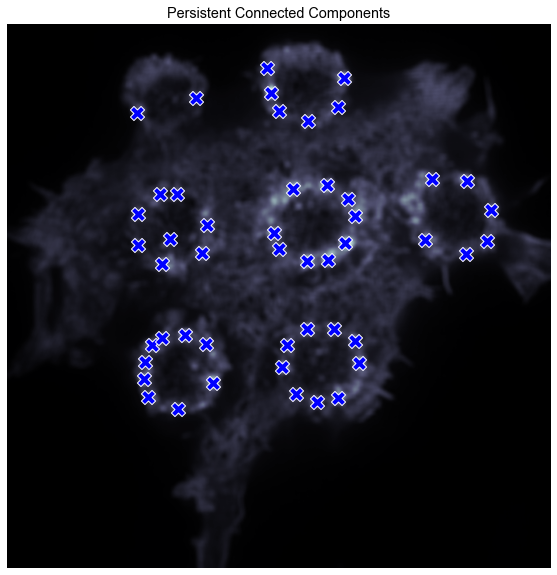

In [57]:
plt.figure(figsize=(10,10))
plt.title('Persistent Connected Components')
plt.imshow(img_pod,cmap=plt.cm.bone)
plt.scatter(pods.T[0],pods.T[1],color='blue',marker = 'X',s=200,edgecolors='white',lw=1)
# plt.scatter(sites.T[0],sites.T[1],color='orange',marker = 'o',s=100,edgecolors='white')
plt.axis('off')
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure3_Methods/IndividualPlots/PreRefinement_H0.pdf",transparent=True,dpi=300,bbox_inches='tight',pad_inches = 0)

plt.show()

In [58]:
p = d.homology_persistence(f_upper_star_sites)
dgms = d.init_diagrams(p, f_upper_star_sites)

pers_dio = []
for h, dgm in enumerate(dgms):
    for pt in dgm:
        pers_dio.append([h,pt.birth,pt.death])

pers_dio = np.asarray(pers_dio)
pers_dio[0,2] = 0

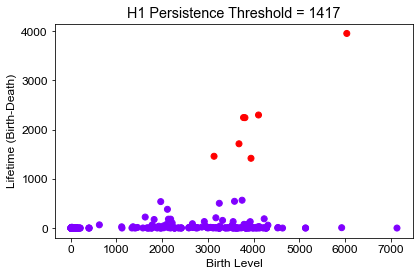

1416.917236328125

In [59]:
kmeans_pers_thresh(pers_dio,1,n=2,plot_bool=True,save_file='')

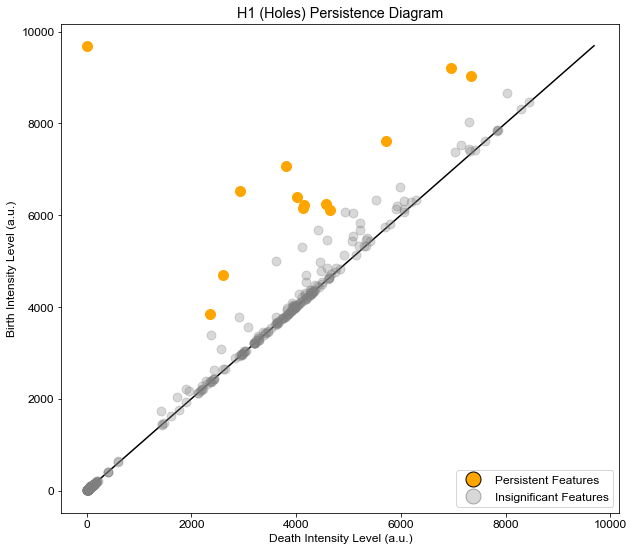

In [60]:
plt.figure(figsize=(10,9))
bt0 = pers_dio[pers_dio.T[0]==0].T[1:][0]
dt0 = pers_dio[pers_dio.T[0]==0].T[1:][1]

plt.scatter(dt0,bt0,alpha=0.3,color='gray',s=80,rasterized=True)

pers_dio_0 = pers_dio[pers_dio.T[0]==0]
pers_dio_sig0 = pers_dio_0[bt0-dt0 > 1417-1]
bt0_sig = pers_dio_sig0.T[1:][0]
dt0_sig = pers_dio_sig0.T[1:][1]

plt.scatter(dt0_sig,bt0_sig,color='orange',s=100,rasterized=True)

plt.title('H1 (Holes) Persistence Diagram')
plt.ylabel('Birth Intensity Level (a.u.)')
plt.xlabel('Death Intensity Level (a.u.)')



custom_lines = [plt.Line2D([0], [0],marker='o', color='None', label='Scatter',
                          markerfacecolor='orange', markersize=15),
                plt.Line2D([0], [0],marker='o', color='None', label='Scatter',
                          markerfacecolor='gray',alpha=0.3, markersize=15)]

plt.legend(custom_lines, ['Persistent Features','Insignificant Features'])

plt.plot([0,np.max(bt0)],[0,np.max(bt0)],c='black',zorder=0)

# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI/IndividualPlots/PersistenceDiagram_H1.pdf",transparent=True,dpi=300,bbox_inches='tight',pad_inches = 0)
plt.show()

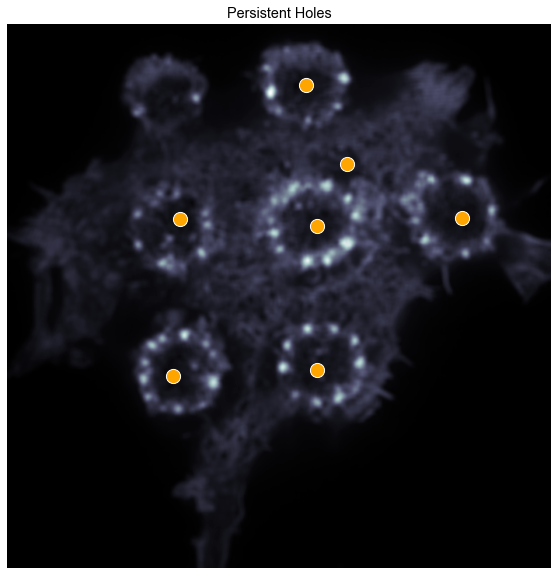

In [61]:
plt.figure(figsize=(10,10))
plt.title('Persistent Holes')
plt.imshow(img_pod,cmap=plt.cm.bone)
# plt.scatter(pods.T[0],pods.T[1],color='None',marker = 'o',s=200,edgecolors='red')
plt.scatter(sites.T[0],sites.T[1],color='orange',marker = 'o',s=200,edgecolors='white',lw=1)
plt.axis('off')
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure3_Methods/IndividualPlots/PreRefinement_H1.pdf",transparent=True,dpi=300,bbox_inches='tight',pad_inches = 0)

plt.show()

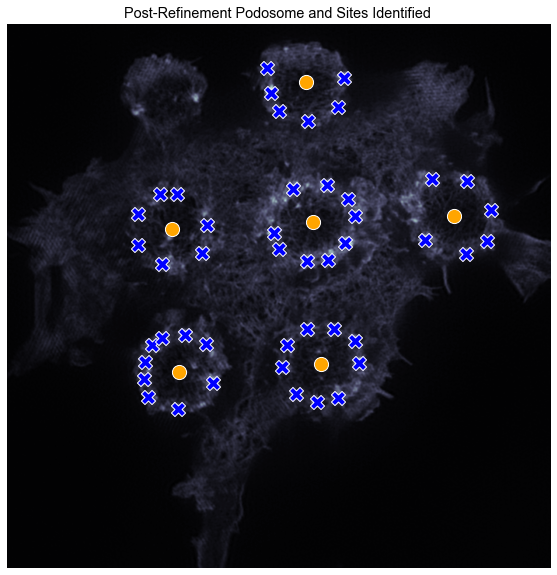

In [63]:
clusters = np.vstack(clusters)

plt.figure(figsize=(10,10))
plt.title('Post-Refinement Podosome and Sites Identified ')
plt.imshow(actin,cmap=plt.cm.bone)

plt.scatter(clusters.T[0],clusters.T[1],color='blue',marker = 'X',s=200,edgecolors='white',lw=1)
plt.scatter(centers.T[0],centers.T[1],color='orange',marker = 'o',s=200,edgecolors='white',lw=1)
plt.axis('off')
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI/IndividualPlots/PostRefinement_Locations.pdf",transparent=True,dpi=300,bbox_inches='tight',pad_inches = 0)

plt.show()